# Analisis & Forecasting Saham BBNI

Oleh: Denny Dewanta

Penjelasan Lengkap: https://medium.com/@dedewanta/studi-kasus-saham-bbni-arima-visualisasi-data-5d57c1340dae

Dataset:
https://www.kaggle.com/tiwill/saham-idx

Dataset tersebut berisi historical data saham BBNI dari tanggal 29 Juli 2019 sampai dengan 9 Juli 2021. Namun saya hanya menggunakan dataset BBNI pada 9 September 2020 sampai dengan 9 Juli 2021. Dataset tersebut berasal dari Bursa Efek Indonesia dan tidak diperkenankan digunakan untuk tujuan komersial.

## Libraries

In [349]:
 !pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error,mean_squared_log_error

## Pre-processing Data

In [350]:
# Import Dataset dari Gdrive
!gdown --id 1mrdO2dXf9YbNnquFr8D44sMo2y_gB3eY #dataset BBNI

Downloading...
From: https://drive.google.com/uc?id=1mrdO2dXf9YbNnquFr8D44sMo2y_gB3eY
To: /content/BBNI.csv
100% 42.2k/42.2k [00:00<00:00, 37.7MB/s]


In [351]:
# Make Dataframe BBNI
df_bbni = pd.read_csv("/content/BBNI.csv")
# To Date
df_bbni['date'] = pd.to_datetime(df_bbni['date'])
df_bbni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   306 non-null    datetime64[ns]
 1   previous               205 non-null    float64       
 2   open_price             205 non-null    float64       
 3   first_trade            205 non-null    float64       
 4   high                   205 non-null    float64       
 5   low                    205 non-null    float64       
 6   close                  205 non-null    float64       
 7   change                 205 non-null    float64       
 8   volume                 205 non-null    float64       
 9   value                  205 non-null    float64       
 10  frequency              205 non-null    float64       
 11  index_individual       205 non-null    float64       
 12  offer                  205 non-null    float64       
 13  offer

In [352]:
df_bbni.head()

,date,previous,open_price,first_trade,high,low,close,change,volume,value,frequency,index_individual,offer,offer_volume,bid,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,delisting_date,non_regular_volume,non_regular_value,non_regular_frequency
0,2020-09-07,5225.0,5225.0,5250.0,5275.0,5125.0,5250.0,25.0,40928200.0,2.128930e+11,8415.0,25.3,5275.0,842900.0,5250.0,225700.0,1.846217e+10,1.846217e+10,1.846217e+10,12264600.0,468700.0,NaN,2108032.0,1.106046e+10,6.0
1,2020-09-08,5250.0,5300.0,5300.0,5300.0,5225.0,5250.0,0.0,22596800.0,1.187250e+11,5217.0,25.3,5275.0,1379400.0,5250.0,665700.0,1.846217e+10,1.846217e+10,1.846217e+10,5933400.0,1428700.0,NaN,3886056.0,2.015139e+10,6.0
2,2020-09-09,5250.0,5150.0,5150.0,5175.0,5025.0,5025.0,-225.0,73421800.0,3.724910e+11,18753.0,24.2,5050.0,467600.0,5025.0,2151300.0,1.846217e+10,1.846217e+10,1.846217e+10,11205600.0,3086600.0,NaN,150019.0,7.548931e+08,2.0
3,2020-09-10,5025.0,4780.0,4790.0,4790.0,4680.0,4680.0,-345.0,132102700.0,6.207160e+11,29916.0,22.5,4680.0,34969800.0,0.0,0.0,1.846217e+10,1.846217e+10,1.846217e+10,22839400.0,8853700.0,NaN,1773977.0,9.021068e+09,9.0
4,2020-09-11,4680.0,4450.0,4450.0,4880.0,4420.0,4870.0,190.0,121461600.0,5.729280e+11,32587.0,23.4,4880.0,431200.0,4870.0,1299600.0,1.846217e+10,1.846217e+10,1.846217e+10,18380400.0,10875100.0,NaN,3612001.0,1.874926e+10,5.0


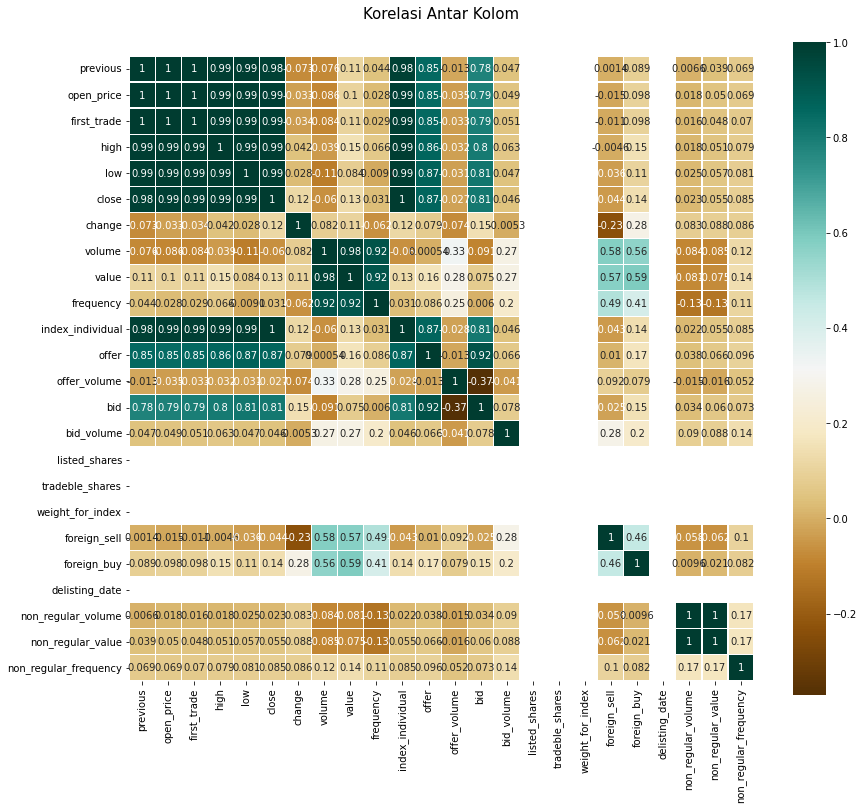

In [353]:
# Korelasi Kolom Data Historical
colormap = plt.cm.BrBG
plt.figure(figsize=(14,12))
plt.title('Korelasi Antar Kolom', y=1.05, size=15)
sns.heatmap(df_bbni.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Dari korelasi di atas, akan dilakukan drop terhadap beberapa kolom.

In [354]:
# Drop Columns
df_bbni.drop(['listed_shares', 'tradeble_shares', 'weight_for_index','delisting_date'], axis = 1, inplace = True)
df_bbni.head()

,date,previous,open_price,first_trade,high,low,close,change,volume,value,frequency,index_individual,offer,offer_volume,bid,bid_volume,foreign_sell,foreign_buy,non_regular_volume,non_regular_value,non_regular_frequency
0,2020-09-07,5225.0,5225.0,5250.0,5275.0,5125.0,5250.0,25.0,40928200.0,2.128930e+11,8415.0,25.3,5275.0,842900.0,5250.0,225700.0,12264600.0,468700.0,2108032.0,1.106046e+10,6.0
1,2020-09-08,5250.0,5300.0,5300.0,5300.0,5225.0,5250.0,0.0,22596800.0,1.187250e+11,5217.0,25.3,5275.0,1379400.0,5250.0,665700.0,5933400.0,1428700.0,3886056.0,2.015139e+10,6.0
2,2020-09-09,5250.0,5150.0,5150.0,5175.0,5025.0,5025.0,-225.0,73421800.0,3.724910e+11,18753.0,24.2,5050.0,467600.0,5025.0,2151300.0,11205600.0,3086600.0,150019.0,7.548931e+08,2.0
3,2020-09-10,5025.0,4780.0,4790.0,4790.0,4680.0,4680.0,-345.0,132102700.0,6.207160e+11,29916.0,22.5,4680.0,34969800.0,0.0,0.0,22839400.0,8853700.0,1773977.0,9.021068e+09,9.0
4,2020-09-11,4680.0,4450.0,4450.0,4880.0,4420.0,4870.0,190.0,121461600.0,5.729280e+11,32587.0,23.4,4880.0,431200.0,4870.0,1299600.0,18380400.0,10875100.0,3612001.0,1.874926e+10,5.0


## Handle Missing Value Data

### Sebelum Interpolasi

In [355]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])
fig1.add_trace(go.Candlestick(x=df_bbni['date'],
                              open=df_bbni['open_price'],
                              high=df_bbni['high'],
                              low=df_bbni['low'],
                              close=df_bbni['close'],
                             ))
fig1.update_layout(title_text='BBNI Stock Price',font=dict(size=12),
                 xaxis_title_text="Date", yaxis_title_text="Stock Price")

Terlihat bahwa harga saham BBNI terdapat beberapa kekosongan. Kekosongan tersebut bisa disebabkan oleh:
1) Memang sengaja tidak direkam pada hari weekend.
2) Memang sengaja tidak direkam pada hari besar atau libur nasional.
3) Memang terdapat kesalahan perekaman data sehingga terdapat missing values.

### Interpolasi Polynomial Orde-5

In [356]:
#Interpolasi Polynomial Orde-5
df_bbni_poly = df_bbni
df_bbni_poly['open_price'] = df_bbni['open_price'].interpolate('polynomial', order=5)
df_bbni_poly['close'] = df_bbni['close'].interpolate('polynomial', order=5)
df_bbni_poly['high'] = df_bbni['high'].interpolate('polynomial', order=5)
df_bbni_poly['low'] = df_bbni['low'].interpolate('polynomial', order=5)

In [357]:
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Candlestick(x=df_bbni_poly['date'],
                              open=df_bbni_poly['open_price'],
                              high=df_bbni_poly['high'],
                              low=df_bbni_poly['low'],
                              close=df_bbni_poly['close'],
                             ))
fig2.update_layout(title_text='BBNI Stock Price (Polynomial Order-5 Interpolation)',font=dict(size=12),
                 xaxis_title_text="Date", yaxis_title_text="Stock Price")

### Interpolasi Linear

In [358]:
#Interpolasi Linear
df_bbni_lin = df_bbni
df_bbni_lin['open_price'] = df_bbni['open_price'].interpolate(method ='linear', limit_direction ='forward')
df_bbni_lin['close'] = df_bbni['close'].interpolate(method ='linear', limit_direction ='forward')
df_bbni_lin['high'] = df_bbni['high'].interpolate(method ='linear', limit_direction ='forward')
df_bbni_lin['low'] = df_bbni['low'].interpolate(method ='linear', limit_direction ='forward')

In [359]:
fig3 = make_subplots(specs=[[{"secondary_y": True}]])
fig3.add_trace(go.Candlestick(x=df_bbni_lin['date'],
                              open=df_bbni_lin['open_price'],
                              high=df_bbni_lin['high'],
                              low=df_bbni_lin['low'],
                              close=df_bbni_lin['close'],
                             ))
fig3.update_layout(title_text='BBNI Stock Price (Linear Interpolation)',font=dict(size=12),
                 xaxis_title_text="Date", yaxis_title_text="Stock Price")

## ARIMA Forecasting (Close)

In [360]:
#Split Dataset
model_train = df_bbni_lin.iloc[:int(df_bbni_lin.shape[0]*0.80)]
model_test = df_bbni_lin.iloc[int(df_bbni_lin.shape[0]*0.80):]

#ntest
ntest = len(model_test)

#Split Dataset untuk semua komponen
train_open = model_train['open_price']
test_open = model_test['open_price']

train_close = model_train['close']
test_close = model_test['close']

train_high = model_train['high']
test_high = model_test['high']

train_low = model_train['low']
test_low = model_test['low']

In [361]:
#Nama df untuk looping
dfTrainName = [train_open, train_close, train_high, train_low]
dfTestName = [test_open, test_close, test_high, test_low]
titlePlot = ['ARIMA Forecasting - BBNI Open','ARIMA Forecasting - BBNI Close','ARIMA Forecasting - BBNI High','ARIMA Forecasting - BBNI Low']

In [362]:
#Nama model untuk looping
modelName = ['modelOpen', 'modelClose', 'modelHigh', 'modelLow']

In [345]:
#Training
for i in range(4):
  globals()[modelName[i]] = pm.auto_arima(dfTrainName[i], start_p=1, start_q=1,
                                          test='adf',
                                          max_p=5, max_q=5,         
                                          d=None,
                                          seasonal=False,
                                          start_P=0,
                                          D=0,
                                          trace=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2973.899, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3043.402, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3019.474, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2973.141, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3041.460, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2971.884, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2961.775, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2956.798, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2958.616, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2958.533, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2953.010, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2952.823, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2951.530, Time=0.22 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2953.224, Time=0.41 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

In [346]:
#Nama df untuk looping
trainPredName = ['trainPred_Open','trainPred_Close','trainPred_High','trainPred_Low']
testPredName = ['testPred_Open','testPred_Close','testPred_High','testPred_Low']

In [347]:
#Predict
for i in range(4):
  globals()[trainPredName[i]] = globals()[modelName[i]].predict_in_sample(start=2)
  globals()[testPredName[i]], conflict = globals()[modelName[i]].predict(n_periods=ntest, return_conf_int=True)

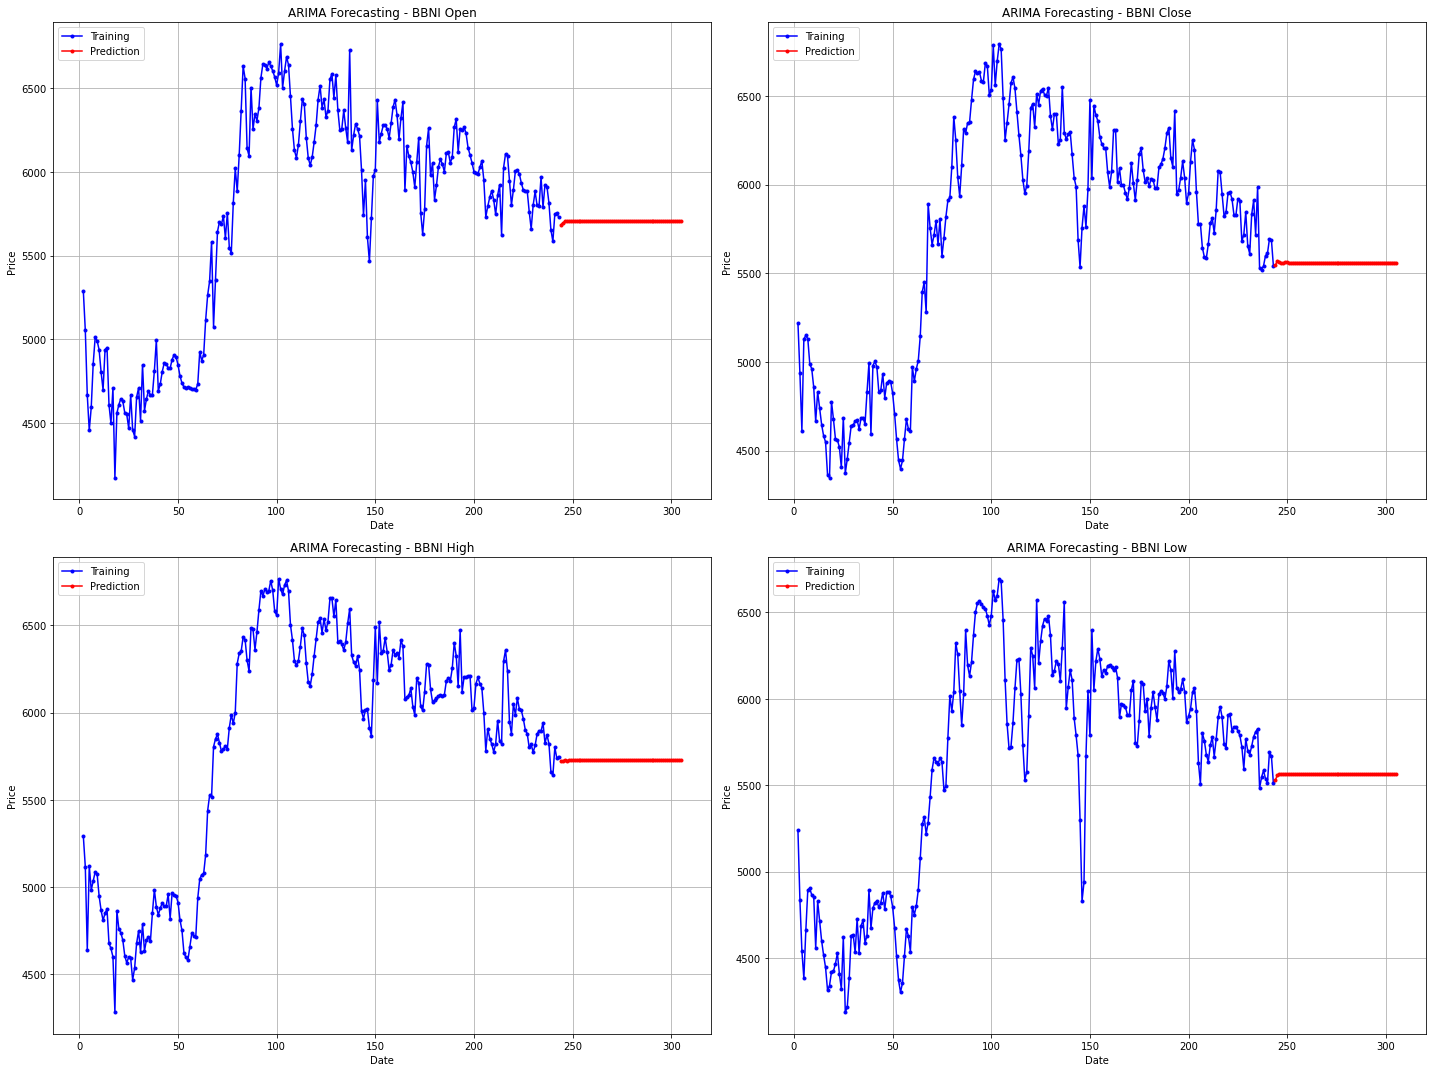

In [364]:
# Plotting data training dan data testing
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
row = 0
col = 0

for i in range(4):
  axs[row, col].plot(dfTrainName[i].index[2:], globals()[trainPredName[i]], label='Training', color='blue', marker = '.')
  axs[row, col].plot(dfTestName[i].index, globals()[testPredName[i]], label='Prediction', color='red', marker='.')
  axs[row, col].legend(loc='upper left')
  axs[row, col].set_title(titlePlot[i])
  axs[row, col].set_xlabel('Date')
  axs[row, col].set_ylabel('Price')
  axs[row, col].grid()

  col = col + 1
  if col == 2:
    row = row + 1
    col = 0

plt.tight_layout()

Penjelasan lengkap: https://medium.com/@dedewanta/studi-kasus-saham-bbni-arima-visualisasi-data-5d57c1340dae